In [1]:
%load_ext cython
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numba import jit
from lmfit import Model, Parameters, Parameter
from lmfit.models import *
from multiprocessing import Pool
import boost_histogram as bh


from scipy import stats
from scipy.optimize import curve_fit

MP = 0.93827208816
E0 = 4.81726
ME = 0.00051099895

In [2]:
%%cython --annotate
import numpy as np
cimport numpy as np
from libc.math cimport sin, cos, sqrt
from scipy import stats
cimport cython

cdef float MP = 0.93827208816
cdef float E0 = 4.81726
cdef float ME = 0.00051099895

cdef float p_targ_px = 0.0
cdef float p_targ_py = 0.0
cdef float p_targ_pz = 0.0
cdef float p_targ_E = MP

cdef float e_beam_px = 0.0
cdef float e_beam_py = 0.0
cdef float e_beam_pz = sqrt(E0**2-ME**2)
cdef float e_beam_E = E0

@np.vectorize
def calc_W(float e_p, float e_theta, float e_phi):
    cdef float e_prime_px = e_p*sin(e_theta)*cos(e_phi)
    cdef float e_prime_py = e_p*sin(e_theta)*sin(e_phi)
    cdef float e_prime_pz = e_p*cos(e_theta)
    cdef float e_prime_E = sqrt(e_prime_px**2 + e_prime_py**2 + e_prime_pz**2 - ME**2)
    
    cdef float temp_px = e_beam_px - e_prime_px + p_targ_px
    cdef float temp_py = e_beam_py - e_prime_py + p_targ_py
    cdef float temp_pz = e_beam_pz - e_prime_pz + p_targ_pz
    cdef float temp_E = e_beam_E - e_prime_E + p_targ_E
    
    
    cdef float temp2 = temp_px**2+temp_py**2+temp_pz**2-temp_E**2
    cdef float temp3 = sqrt(-temp2)
    return temp3


@np.vectorize
def calc_q2(float e_p, float e_theta, float e_phi):
    cdef float e_prime_px = e_p*sin(e_theta)*cos(e_phi)
    cdef float e_prime_py = e_p*sin(e_theta)*sin(e_phi)
    cdef float e_prime_pz = e_p*cos(e_theta)
    cdef float e_prime_E = sqrt(e_prime_px**2 + e_prime_py**2 + e_prime_pz**2 - ME**2)
    
    cdef float temp_px = e_beam_px - e_prime_px
    cdef float temp_py = e_beam_py - e_prime_py
    cdef float temp_pz = e_beam_pz - e_prime_pz
    cdef float temp_E = e_beam_E - e_prime_E

    cdef float temp2 = temp_px**2+temp_py**2+temp_pz**2-temp_E**2

    return temp2


@np.vectorize
def correct_W(e_p, theta, A, B, C, D, E, F):
    return A*calc_W(B*e_p + E, C*theta + F, np.zeros_like(e_p))+D

@np.vectorize
def correct_Q2(e_p, theta, A, B, C, D, E, F):
    return A*calc_q2(B*e_p + E, C*theta + F, np.zeros_like(e_p))+D

@cython.embedsignature(True)
def FitWHist(X, A, B, C, D, E, F):
    e_p, theta = X
    w_new = correct_W(e_p, theta, A, B, C, D, E, F)
    w_new = w_new[np.isfinite(w_new)]
    mu, std = stats.norm.fit(w_new)
    return np.sqrt((mu-MP)**2 + (std)**2) 

In [3]:
@np.vectorize
def center_phi(phi, sec):
    sector = {
        1: 90,
        2: 30,
        3: -30,
        4: -90,
        5: -150,
        6: 150
    }
    
    return phi-sector[sec]

@np.vectorize
def Theta_e_calc(theta_p):
    return 2 * np.arctan(MP/((E0+MP)*np.tan(theta_p)))

def gauss(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))



def FitFunc(phi_e, theta_e, 
            alpha_A, beta_A, gamma_A, 
            alpha_B, beta_B, gamma_B, 
            alpha_C, beta_C, gamma_C,
            alpha_D, beta_D, gamma_D,
            alpha_E, beta_E, gamma_E):
    """
    Equations 5.20 - 5.22 in KPark thesis (p. 71)
    """
    A = (alpha_A * theta_e**2 + beta_A * theta_e + gamma_A) * phi_e**4
    B = (alpha_B * theta_e**2 + beta_B * theta_e + gamma_B) * phi_e**3
    C = (alpha_C * theta_e**2 + beta_C * theta_e + gamma_C) * phi_e**2
    D = (alpha_D * theta_e**2 + beta_D * theta_e + gamma_D) * phi_e
    E = (alpha_E * theta_e**2 + beta_E * theta_e + gamma_E)
    
    return A + B + C + D + E


def Dtheta(phi_e, theta_e, A, B, C, D, Bt):
    """
    Mom Corrections for e6 (CLAS-NOTE 2003-005) 
    """
    first = (A+B*phi_e)*(np.cos(theta_e)/np.cos(phi_e))
    second = (C+D*phi_e)*np.sin(theta_e)
    return first + second

def Dpp(phi_e, theta_e, p, E, F, G, H):
    first = (E+F*phi_e)*(np.cos(theta_e)/np.cos(phi_e))
    second = (G+H*phi_e)*np.sin(theta_e)
    
    return (first + second)*(p/Bt)
    

# def _FitWHist(X, A, B, C, D, E, F):
#     return FitWHist(X, A, B, C, D, E, F)

In [4]:
df = pd.read_csv("mom_corr_elastic.dat")

df = df[(df.W_uncorr > 0.85) & (df.W_uncorr < 1.2)]
df['e_theta'] = np.deg2rad(df.e_theta)
df['e_phi_center'] = np.deg2rad(center_phi(df.e_phi, df.sector))
df['e_phi'] = np.deg2rad(df.e_phi)
df['p_theta'] = np.deg2rad(df.p_theta)
df['p_phi'] = np.deg2rad(df.p_phi)
df['e_theta_calc'] = Theta_e_calc(df.p_theta)
df['delta_theta'] = df['e_theta_calc']-df['e_theta']
%time df['w_corr'] = calc_W(df.e_p.to_numpy(), df.e_theta.to_numpy(), df.e_phi.to_numpy())
%time df['q2_corr'] = calc_q2(df.e_p.to_numpy(), df.e_theta.to_numpy(), df.e_phi.to_numpy())
df['p_p_calc'] = Theta_e_calc(df.e_theta_calc)



CPU times: user 40.5 ms, sys: 18.8 ms, total: 59.4 ms
Wall time: 59.5 ms
CPU times: user 41.8 ms, sys: 13.2 ms, total: 55 ms
Wall time: 54.4 ms


In [5]:
df.head()

,e_p,e_theta,e_phi,p_p,p_theta,p_phi,W_uncorr,Q2_uncorr,sector,e_phi_center,e_theta_calc,delta_theta,w_corr,q2_corr,p_p_calc
0,3.867114,0.302877,-0.630023,1.606884,0.822251,2.523154,0.983592,1.695892,3,-0.106424,0.300571,-0.002306,0.983591,1.695893,0.968364
2,3.823474,0.320880,1.468849,1.707246,0.789636,-1.651257,0.930052,1.880240,1,-0.101948,0.320518,-0.000362,0.930053,1.880239,0.912973
4,3.808950,0.320004,2.788525,1.675734,0.789702,-0.359243,0.953690,1.862967,6,0.170531,0.320476,0.000472,0.953689,1.862969,0.913083
5,4.044248,0.268281,-1.527046,1.388920,0.881333,1.606775,0.968046,1.393833,4,0.043751,0.267199,-0.001082,0.968044,1.393835,1.074239
6,3.907971,0.292540,1.706743,1.572335,0.835882,-1.425245,0.993494,1.599645,1,0.135946,0.292574,0.000033,0.993494,1.599645,0.992134


In [6]:
def FitWHist(X, A, B, C, D, E, F):
    e_p, theta = X
    w_new = correct_W(e_p, theta, A, B, C, D, E, F)
    w_new = w_new[np.isfinite(w_new)]
    y, x = np.histogram(w_new, bins=100, density=True)
    x = (x[1:] + x[:-1]) / 2
    
    model = PseudoVoigtModel(prefix="peak_")
    pars = model.guess(y, x=x)
    out = model.fit(y, pars, x=x)
    
    mu = out.params['peak_center']
    std = out.params['peak_fwhm'] / 2.355
    
    return np.sqrt((mu-MP)**2 + (std)**2) 

def fit_method(input_dict):
    sector_q2_df = input_dict['data']
    model = Model(FitWHist)
    params = Parameters()

    params['A'] = Parameter(name='A', value=1.0, min=0.95, max=1.5)
    params['B'] = Parameter(name='B', value=1.0, min=0.95, max=1.5)
    params['C'] = Parameter(name='C', value=1.0, min=0.95, max=1.5)

    params['D'] = Parameter(name='D', value=0.0, min=-0.5, max=0.5)
    params['E'] = Parameter(name='E', value=0.0, min=-0.5, max=0.5)
    params['F'] = Parameter(name='F', value=0.0, min=-0.5, max=0.5)
    try:
        result = model.fit(np.zeros_like(sector_q2_df.e_p), params, 
                       X=(sector_q2_df.e_p.to_numpy(), sector_q2_df.e_theta.to_numpy()))
    except ValueError as e:
        return {'sec' : sec, 'momentum' : momentum, 'result' : None}
    
    print(*result.best_values.values())
    sector_q2_df['w_corr_lmfit'] = correct_W(sector_q2_df.e_p, sector_q2_df.e_theta, *result.best_values.values())
    sector_q2_df['q2_corr_lmfit'] = correct_Q2(sector_q2_df.e_p, sector_q2_df.e_theta, *result.best_values.values())

    plt.hist(sector_q2_df.w_corr_lmfit, bins=500,alpha=0.8)
    plt.hist(sector_q2_df.W_uncorr, bins=500, alpha=0.2)
    plt.axvline(MP)
    plt.show()
    
    return {'sec' : sec, 'momentum' : momentum, 'result' : result}


In [7]:
%time FitWHist((df.e_p,df.e_theta),0.95,1,1,0,0,0)

CPU times: user 4.6 s, sys: 109 ms, total: 4.71 s
Wall time: 4.66 s


0.032555449124957

1 1.5
1 2.0
1 2.5
1 3.0
1 3.5
2 1.5
2 2.0
2 2.5
2 3.0
2 3.5
3 1.5
3 2.0
3 2.5
3 3.0
3 3.5
4 1.5
4 2.0
4 2.5
4 3.0
4 3.5
5 1.5
5 2.0
5 2.5
5 3.0
5 3.5
0.9933485945570345 1.0 1.0 0.008063253107701507 0.0 0.0
1.0034990409515812 1.0 1.0 0.0024729766731564906 0.0 1.00178328472499810.0 
1.0 1.0 0.0020341476312668583 0.0 0.0


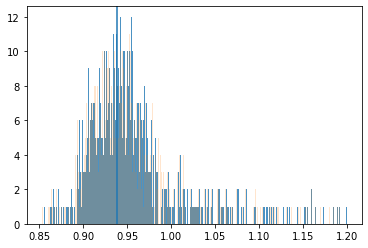

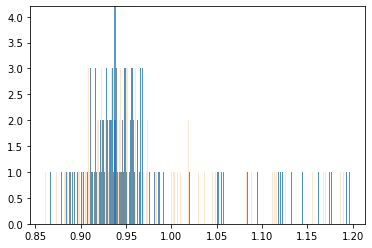

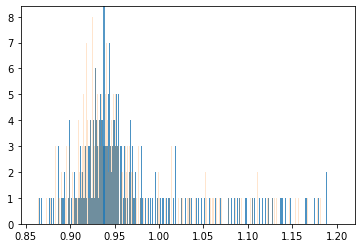

0.9979150173756516 1.0 1.0 -0.0019472660767519412 0.0 0.0
0.9512849149882676 1.0 1.0 0.029647492992630364 0.0 0.0


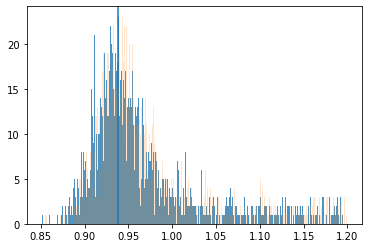

0.9990124614016382 1.0 1.0 -0.001290554052758297 0.0 

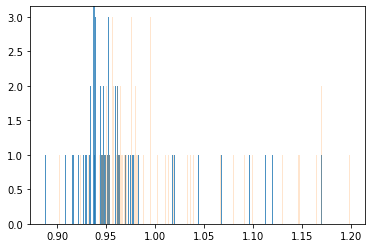

0.0
0.9808923329090616 1.0 1.0 -0.021764356890662806 0.0 0.0


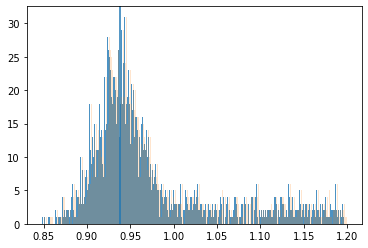

1.0010713247794731 1.0 1.0 0.004254458431602104 0.0 0.004495711951830628


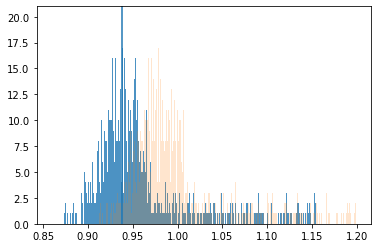

0.9611704736026792 1.0 1.0 0.002033158612914865 0.0 0.0


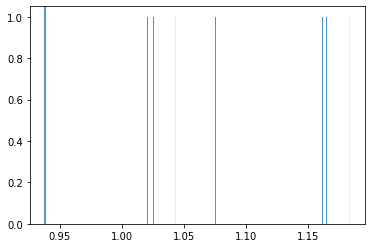

0.9999999836110617 1.0 1.0 2.428651014740879e-07 0.0 0.0


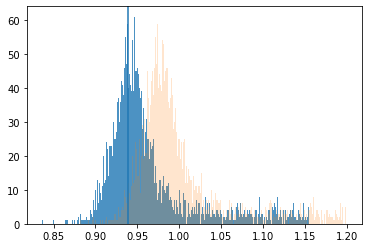

0.9981514674423648 1.0 1.0 -0.005396903812768583 0.0 0.0


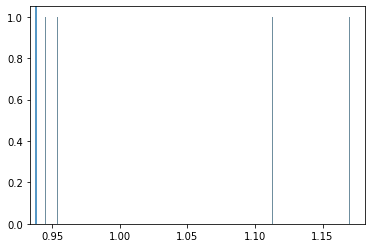

0.9963209647999902 1.0 1.0 -0.002917413582670225 0.0 0.0


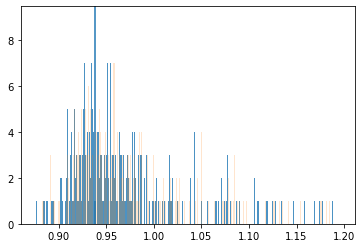

0.9512399552180895 1.0 1.0 0.028197484270686246 0.0 0.0


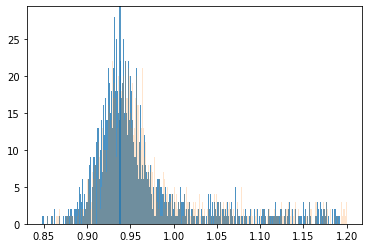

0.9946414587780971 1.0 1.0 -0.005649119089831456 0.0 0.0


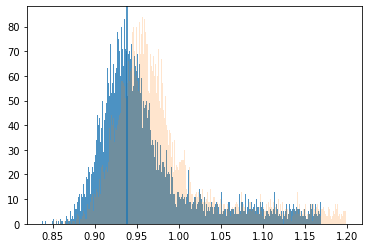

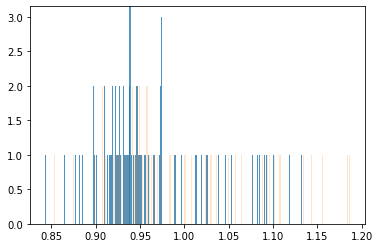

1.0 1.0 1.0 0.0 0.0 0.0
0.9939616363748462 1.0 1.0 -0.0061948880061108436 0.0 0.0
0.9774323115332608 1.0 1.0 0.00330414854736516 0.0 0.0


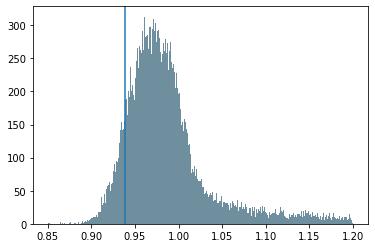

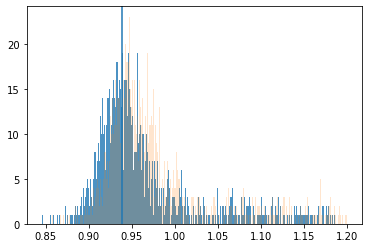

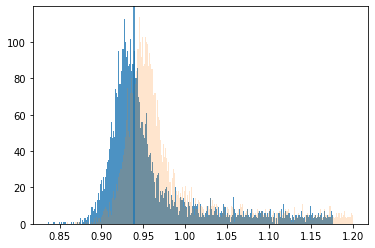

0.9822272017438936 1.000162175548085 1.0 -0.020321730697724527 0.0005348027212799256 -0.0002368185443509252
0.9539982324137631 1.0 1.0 0.029942893281196703 0.0 0.0


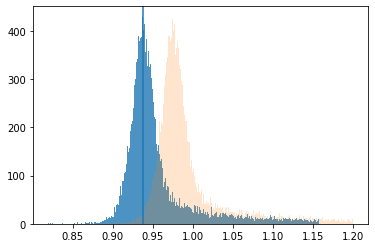

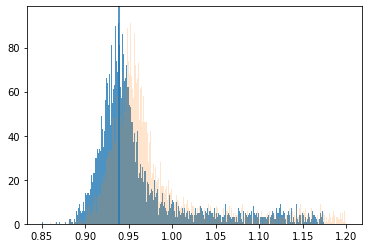

0.9999998347413479 1.0 1.0 -6.696626221325275e-07 0.0 0.0


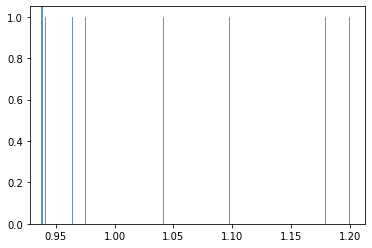

0.9672856220745418 1.0 0.9999776720169499 0.014505785301387686 0.0 -5.64500003953361e-05
1.0000000225682328 1.0 1.0 3.190180656176267e-05 0.0 0.0


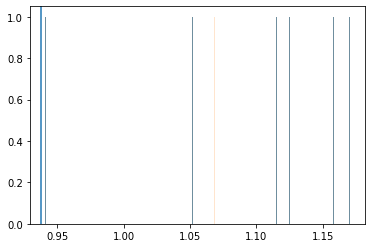

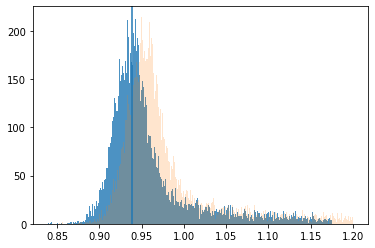

1.0218822250082729 1.0 1.0 -0.04264628141847515 0.0 0.0


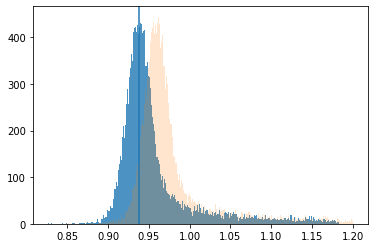

TypeError: Improper input: N=6 must not exceed M=2

In [11]:
data_to_fit = []

for sec in range(1,7):
    for momentum in np.arange(1.5, 4.0, 0.5):
        data = df[(df.sector == sec) & (df.e_p >= momentum) & (df.e_p < momentum+0.5)].copy()
        print(sec, momentum)
        data_to_fit.append({'sec' : sec, 'momentum' : momentum, 'data' : data})
        

with Pool(8) as p:
    results = p.map(fit_method, data_to_fit)

In [10]:
results

[{'sec': 5,
  'momentum': 3.5,
  'result': <lmfit.model.ModelResult at 0x7f31ddc2b390>},
 {'sec': 5,
  'momentum': 3.5,
  'result': <lmfit.model.ModelResult at 0x7f31dfe28690>},
 {'sec': 5,
  'momentum': 3.5,
  'result': <lmfit.model.ModelResult at 0x7f31dfcdbed0>},
 {'sec': 5,
  'momentum': 3.5,
  'result': <lmfit.model.ModelResult at 0x7f31dfe30b90>},
 {'sec': 5,
  'momentum': 3.5,
  'result': <lmfit.model.ModelResult at 0x7f31ddc4e110>},
 {'sec': 5, 'momentum': 3.5, 'result': None},
 {'sec': 5,
  'momentum': 3.5,
  'result': <lmfit.model.ModelResult at 0x7f31ddc2bdd0>},
 {'sec': 5,
  'momentum': 3.5,
  'result': <lmfit.model.ModelResult at 0x7f31ddc39190>},
 {'sec': 5,
  'momentum': 3.5,
  'result': <lmfit.model.ModelResult at 0x7f31dfcc4950>},
 {'sec': 5,
  'momentum': 3.5,
  'result': <lmfit.model.ModelResult at 0x7f31ddc1a850>},
 {'sec': 5,
  'momentum': 3.5,
  'result': <lmfit.model.ModelResult at 0x7f31dfce2bd0>},
 {'sec': 5,
  'momentum': 3.5,
  'result': <lmfit.model.ModelRes